## Motorcycle Data Set
##### Load the data from the csv file and print the 1st few rows

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/zief0002/urban-memory/master/data/mcycle.csv"
df = pd.read_csv(url)

df.head()


,times,accel
0,2.4,0.0
1,2.6,-1.3
2,3.2,-2.7
3,3.6,0.0
4,4.0,-2.7


##### Plot raw data to visualize it

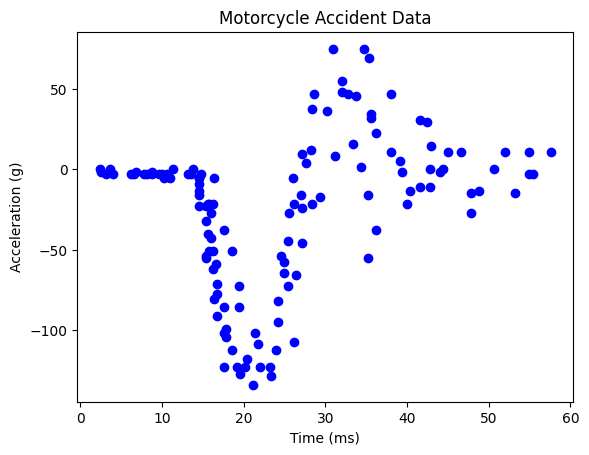

In [2]:
import matplotlib.pyplot as plt

plt.scatter(df['times'], df['accel'], color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('Acceleration (g)')
plt.title('Motorcycle Accident Data')
plt.show()


##### There is a strong fall and rise, it looks nonlinear and noisy.

#### Pick Kernels

##### Considerations: 
##### Matern 5/2 for the main trend to capture smoothness and roughness. 
##### RQ for some flexibility 
##### white noise kernel to model measurement error ]
#### GPR model:

In [3]:
import numpy as np
from easyGPR_helper import GPRModel, set_gpytorch_settings
import torch
import gpytorch
import time
import matplotlib.pyplot as plt



In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import sys
sys.path.append('./reu')

from easyGPR_helper import set_gpytorch_settings, GPRModel
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, RQKernel

set_gpytorch_settings()

In [6]:
## Data preperation
X = df['times'].values.reshape(-1, 1)
y = df['accel'].values

# Convert to numpy
x_train = np.array(X)
y_train = np.array(y)


In [7]:
## Kernel Definiton

# RBF kernel
k1 = ScaleKernel(RBFKernel())

# Matern 5/2 kernel
k2 = ScaleKernel(MaternKernel(nu=2.5))

# Rational Quadratic kernel
k3 = ScaleKernel(RQKernel())

# Build models
m1 = GPRModel(train_x=x_train, train_y=y_train, kernel=k1)
m2 = GPRModel(train_x=x_train, train_y=y_train, kernel=k2)
m3 = GPRModel(train_x=x_train, train_y=y_train, kernel=k3)

# Train models

print("RBF Kernel")
t0 = time.perf_counter()
m1.fit_model(training_iterations=200, lr=0.1)
elapsed = time.perf_counter() - t0
print(f"Training took {elapsed:.2f} s")

print("Matern 5/2 Kernel")
t0 = time.perf_counter()
m2.fit_model(training_iterations=200, lr=0.1)
elapsed2 = time.perf_counter() - t0
print(f"Training took {elapsed2:.2f} s")

print("Rational Quadratic Kernel")
t0 = time.perf_counter()
m3.fit_model(training_iterations=200, lr=0.1)
elapsed3 = time.perf_counter() - t0
print(f"Training took {elapsed3:.2f} s")



RBF Kernel
Fitting complete.
--- 
--- final mll: -67.3653
--- num_params: 4
--- BIC: 8949.6956
Training took 5.29 s
Matern 5/2 Kernel
Fitting complete.
--- 
--- final mll: -65.4068
--- num_params: 4
--- BIC: 8689.1779
Training took 2.31 s
Rational Quadratic Kernel
Fitting complete.
--- 
--- final mll: -66.7743
--- num_params: 5
--- BIC: 8873.6152
Training took 3.62 s


In [8]:
### Hyperparameters
from IPython.display import display

print("RBF Hyperparameters:")
display(m1.get_hyperparameters_df())

print("Matern 5/2 Hyperparameters:")
display(m2.get_hyperparameters_df())

print("Rational Quadratic Hyperparameters:")
display(m3.get_hyperparameters_df())

RBF Hyperparameters:


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,4.077454
1,mean_module.constant,-10.605509
2,kernel.outputscale,6.571619
3,kernel.base_kernel.lengthscale,0.051618


Matern 5/2 Hyperparameters:


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,4.357727
1,mean_module.constant,-11.886759
2,kernel.outputscale,5.406141
3,kernel.base_kernel.lengthscale,0.056986


Rational Quadratic Hyperparameters:


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,4.228534
1,mean_module.constant,-12.989339
2,kernel.outputscale,5.727094
3,kernel.base_kernel.lengthscale,0.036408
4,kernel.base_kernel.alpha,1.270021


##### Matern 5/2 is doing better as infered because the data isn't super smooth.

In [9]:

x_min_eval, x_max_eval = df['times'].min(), df['times'].max()
n_x_eval = 300  # number of points for smoother curve

In [10]:
# Create  grid
x_eval = np.linspace(x_min_eval, x_max_eval, n_x_eval).reshape(-1, 1)

# Get predictions 
predictions_m1 = m1.make_predictions(x_eval, return_type="numpy")
predictions_m2 = m2.make_predictions(x_eval, return_type="numpy")
predictions_m3 = m3.make_predictions(x_eval, return_type="numpy")

models = [
    ('RBF', predictions_m1),
    ('Matern 5/2', predictions_m2),
    ('Rational Quadratic', predictions_m3)
]

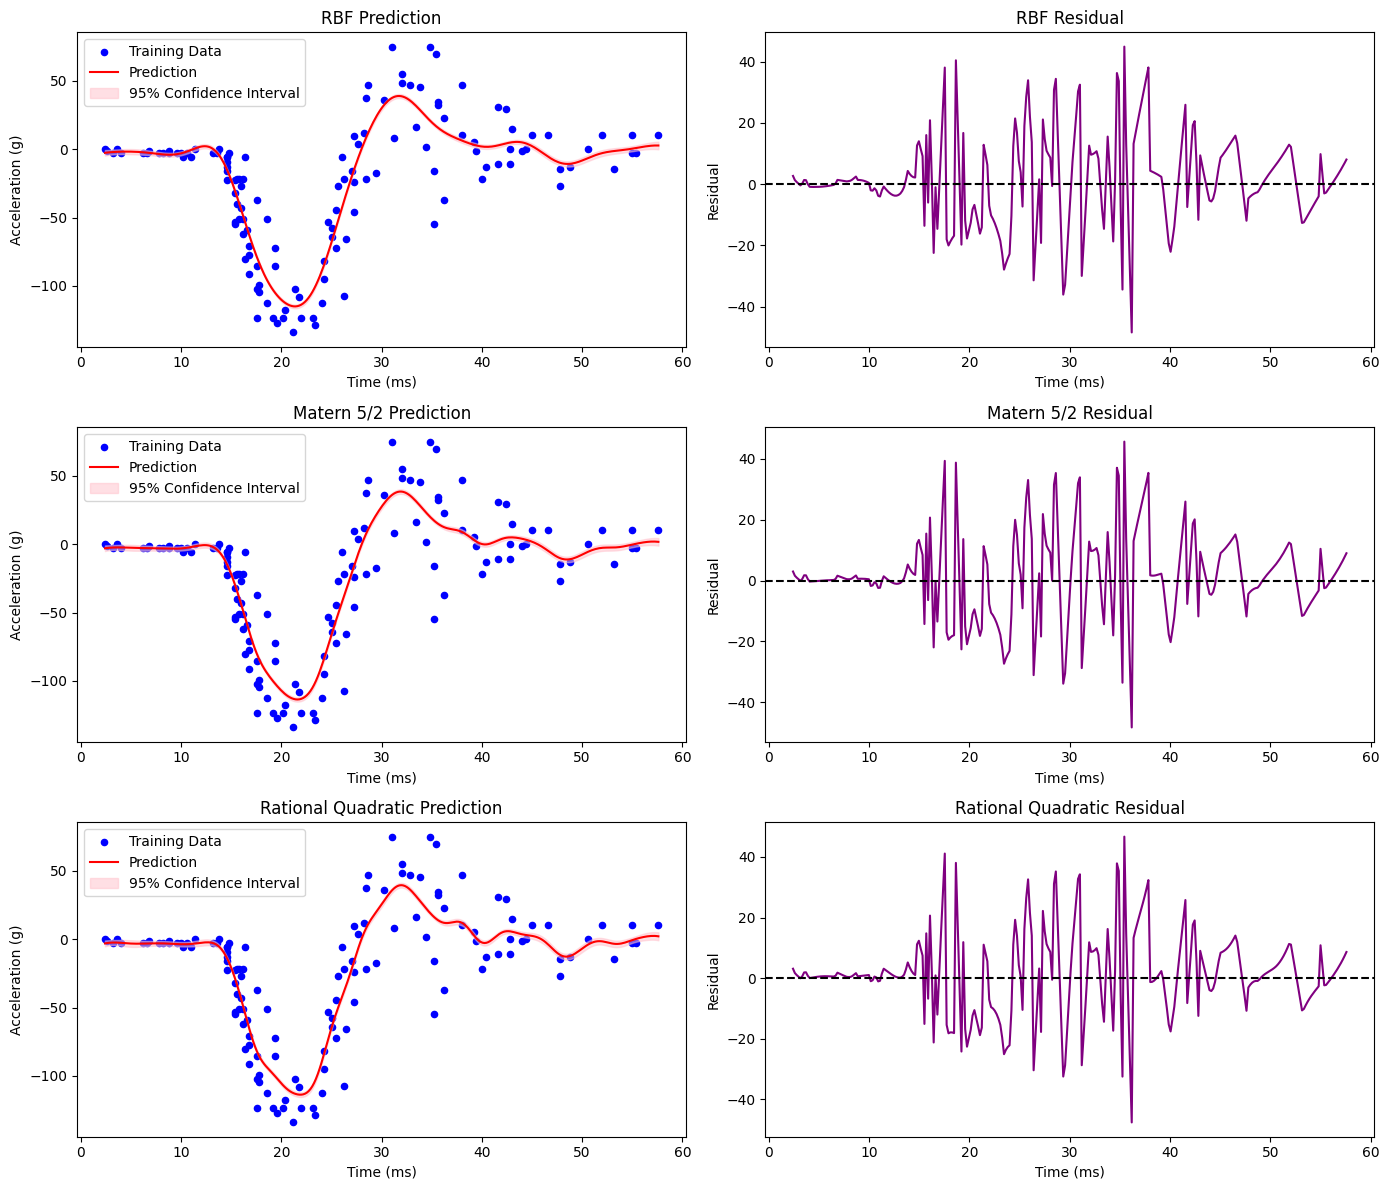

In [11]:

#Plotting
fig, axes = plt.subplots(len(models), 2, figsize=(14, 12))

for row, (model_name, pred) in enumerate(models):
    
 
    mean = pred.mean.flatten()
    variance = pred.variance.flatten()

    # Calculate confidence intervals
    std_dev = np.sqrt(variance)
    upper = mean + 2 * std_dev
    lower = mean - 2 * std_dev


    # Prediction with confidence interval
    axes[row, 0].scatter(df['times'], df['accel'], color='blue', label="Training Data", s=20)
    axes[row, 0].plot(x_eval.flatten(), mean, color='red', label="Prediction")
    axes[row, 0].fill_between(x_eval.flatten(), lower, upper, color='pink', alpha=0.5, label="95% Confidence Interval")
    axes[row, 0].set_title(f'{model_name} Prediction')
    axes[row, 0].set_xlabel('Time (ms)')
    axes[row, 0].set_ylabel('Acceleration (g)')
    axes[row, 0].legend()

    # Residuals
    y_eval = np.interp(x_eval.flatten(), df['times'], df['accel'])
    residual = y_eval - mean
    axes[row, 1].plot(x_eval.flatten(), residual, color='purple')
    axes[row, 1].axhline(0, linestyle='--', color='black')
    axes[row, 1].set_title(f'{model_name} Residual')
    axes[row, 1].set_xlabel('Time (ms)')
    axes[row, 1].set_ylabel('Residual')

plt.tight_layout()
plt.show()


### Composite Kernel 
##### Multiplying the base kernel (Matern 5/2) by Sigma Kernel (square and abs)

In [13]:
from gpytorch.kernels import ScaleKernel, MaternKernel
from kernels import SigmaKernel

# Build SigmaKernel
sigma_kernel = SigmaKernel(power='square')  

# Base kernel (Matern 5/2)
base_kernel = MaternKernel(nu=2.5)

# Full composite kernel
composite_kernel = ScaleKernel(sigma_kernel * base_kernel)


In [14]:
model = GPRModel(train_x=x_train, train_y=y_train, kernel=composite_kernel)
model.fit_model(training_iterations=200, lr=0.1)


Fitting complete.
--- 
--- final mll: -65.5746
--- num_params: 5
--- BIC: 8713.8714


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (kernel): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): SigmaKernel(
          (raw_alpha_constraint): Positive()
        )
        (1): MaternKernel(
          (raw_lengthscale_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [15]:
from gpytorch.kernels import ScaleKernel, MaternKernel
from kernels import SigmaKernel

# Build SigmaKernel
sigma_kernel = SigmaKernel(power='abs')  

# Base kernel (Matern 5/2)
base_kernel = MaternKernel(nu=2.5)

# Full composite kernel
composite_kernel = ScaleKernel(sigma_kernel * base_kernel)

In [16]:
model = GPRModel(train_x=x_train, train_y=y_train, kernel=composite_kernel)
model.fit_model(training_iterations=200, lr=0.1)


Fitting complete.
--- 
--- final mll: -66.3403
--- num_params: 5
--- BIC: 8815.4701


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (kernel): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): SigmaKernel(
          (raw_alpha_constraint): Positive()
        )
        (1): MaternKernel(
          (raw_lengthscale_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
)

##### Multiplying base kernel Matern 5/2 by /SineSigmaKernel 

In [17]:
from gpytorch.kernels import ScaleKernel, MaternKernel
from kernels import SineSigmaKernel 

In [18]:
# Build the kernel
sigma_kernel = SineSigmaKernel()
base_kernel = MaternKernel(nu=2.5)
composite_kernel = ScaleKernel(sigma_kernel * base_kernel)

# Train 
model = GPRModel(train_x=x_train, train_y=y_train, kernel=composite_kernel)
model.fit_model(training_iterations=200, lr=0.1)

Fitting complete.
--- 
--- final mll: -66.3514
--- num_params: 5
--- BIC: 8816.9485


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (kernel): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): SineSigmaKernel(
          (raw_alpha_constraint): Positive()
        )
        (1): MaternKernel(
          (raw_lengthscale_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
)